In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def find_baseline_moving_avg(file_list, window_size, theta=0.5):  
    if len(file_list) == 1:
        df=pd.read_csv(file_list[0], sep=',', skiprows = 0, header= 1)
        data = df['r']
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            y_val = df['r']
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            data[i,:] = df['r'].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-theta*smoothed_std, smoothed_avg+theta*smoothed_std
    
def find_drpo_moving_avg(file_list, window_size, theta = 0.5):  
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', header= None)
            y_val = df[1]
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', header= None)
            data[i,:] = df[1].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-theta*smoothed_std, smoothed_avg+theta*smoothed_std

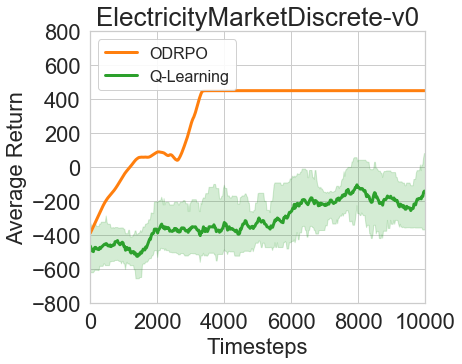

In [6]:
sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

qlearning_file_list = ['./tmp/qlearning_electricitymarketdiscrete_monitor2.csv']
odrpo_file_list = ['./log_files/dr_trpo_kl/ElectricityMarketDiscreteDQN-v0-1618878300.136684.csv']
window_size = 30
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Timesteps', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,10000)
plt.ylim(-800,800)
plt.title('ElectricityMarketDiscrete-v0', fontsize = 26)


# ODRPO 
eps_per_iter = 24
moving_average = find_drpo_moving_avg(odrpo_file_list, window_size,0.5)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='ODRPO', linewidth = 3, color = "tab:orange")
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2, color = "tab:orange")


# Q-Learning
eps_per_iter = 24
moving_average = find_baseline_moving_avg(qlearning_file_list, window_size,0.5)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='Q-Learning', linewidth = 3, color = "tab:green")
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2, color = "tab:green")


plt.rcParams["legend.framealpha"] = 0.9
ax.legend(loc='upper left', fontsize = 16)